In [1]:
# Import libraries
import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim
import pickle
!pwd

/nfs/u50/zhanh279/SemEval-2026/subTask1/Baselines


In [2]:
train_embeddings=pd.read_pickle('../data/task1_embedding_train.pickle')
val_embeddings=pd.read_pickle('../data/task1_embedding_val.pickle')
train_sims=pd.read_pickle('../data/train+sim.pickle')
val_sims=pd.read_pickle('../data/val+sim.pickle')
train_LIWC=pd.read_pickle("../data/task1_LIWC_train.pickle")
val_LIWC=pd.read_pickle("../data/task1_LIWC_val.pickle")

In [3]:
# Check data structure
print("Data shapes:")
print(f"  train_embeddings: {train_embeddings.shape}")
print(f"  val_embeddings: {val_embeddings.shape}")
print(f"  train_sims: {train_sims.shape}")
print(f"  val_sims: {val_sims.shape}")
print(f"  train_LIWC: {train_LIWC.shape}")
print(f"  val_LIWC: {val_LIWC.shape}")

print("\nColumns in train_embeddings:")
print(list(train_embeddings.columns))

print("\nColumns in train_sims:")
print(list(train_sims.columns))

print("\nColumns in train_LIWC:")
print(list(train_LIWC.columns)[:10])


Data shapes:
  train_embeddings: (2211, 9)
  val_embeddings: (553, 9)
  train_sims: (2211, 18)
  val_sims: (553, 18)
  train_LIWC: (2211, 90)
  val_LIWC: (553, 90)

Columns in train_embeddings:
['user_id', 'text_id', 'text', 'timestamp', 'collection_phase', 'is_words', 'valence', 'arousal', 'embedding']

Columns in train_sims:
['user_id', 'text_id', 'text', 'timestamp', 'collection_phase', 'is_words', 'valence', 'arousal', 'Arousal.0.sim', 'Arousal.1.sim', 'Arousal.2.sim', 'Arousal.3.sim', 'Arousal.4.sim', 'Valence.0.sim', 'Valence.1.sim', 'Valence.2.sim', 'Valence.3.sim', 'Valence.4.sim']

Columns in train_LIWC:
['user_id', 'text_id', 'text', 'timestamp', 'collection_phase', 'is_words', 'valence', 'arousal', 'text_tokens', 'text_liwc_tokens']


In [4]:
# Data preparation: combine all features (LIWC + Embedding + Sims + User embedding)


print("=" * 70)
print("FULL BASELINE MODEL: LIWC + EMBEDDING + SIMS + USER_ID")
print("=" * 70)

# Load target data
train_targets = pd.read_pickle("../data/train.pickle")
val_targets = pd.read_pickle("../data/val.pickle")

# Reset indices for alignment
train_sims = train_sims.reset_index(drop=True)
val_sims = val_sims.reset_index(drop=True)
train_LIWC = train_LIWC.reset_index(drop=True)
val_LIWC = val_LIWC.reset_index(drop=True)
train_embeddings = train_embeddings.reset_index(drop=True)
val_embeddings = val_embeddings.reset_index(drop=True)
train_targets = train_targets.reset_index(drop=True)
val_targets = val_targets.reset_index(drop=True)

# Extract user IDs and targets
train_user_ids = train_targets['user_id'].values
val_user_ids = val_targets['user_id'].values
y_train = train_targets[['valence', 'arousal']].values.astype(float)
y_val = val_targets[['valence', 'arousal']].values.astype(float)

# Extract LIWC features (numeric columns only, skip metadata and targets)
# Exclude: user_id, text_id, valence, arousal, collection_phase, is_words, num_tokens
exclude_cols = ['user_id', 'text_id', 'valence', 'arousal', 'collection_phase', 'is_words', 'num_tokens']
liwc_feature_cols = [col for col in train_LIWC.columns if col not in exclude_cols and col not in ['text', 'timestamp', 'text_tokens', 'text_liwc_tokens']]
train_liwc_features = train_LIWC[liwc_feature_cols].values.astype(float)
val_liwc_features = val_LIWC[liwc_feature_cols].values.astype(float)

# Standardize LIWC features
scaler_liwc = StandardScaler()
train_liwc_features = scaler_liwc.fit_transform(train_liwc_features)
val_liwc_features = scaler_liwc.transform(val_liwc_features)

# Embedding features - extract from 'embedding' column
train_emb_features = np.array([np.array(x) for x in train_embeddings['embedding'].values])
val_emb_features = np.array([np.array(x) for x in val_embeddings['embedding'].values])

# Extract sim features (columns with 'sim' in name)
sim_cols = [col for col in train_sims.columns if 'sim' in col.lower()]
train_sim_features = train_sims[sim_cols].values.astype(float)
val_sim_features = val_sims[sim_cols].values.astype(float)

# Standardize sim features
scaler_sim = StandardScaler()
train_sim_features = scaler_sim.fit_transform(train_sim_features)
val_sim_features = scaler_sim.transform(val_sim_features)

# save scalers
pickle.dump(scaler_liwc, open("../scaler_liwc.pkl", "wb"))
pickle.dump(scaler_sim, open("../scaler_sim.pkl", "wb"))

print(f"\nFeature dimensions:")
print(f"  LIWC: {train_liwc_features.shape[1]}")
print(f"  Embedding: {train_emb_features.shape[1]}")
print(f"  Sims: {train_sim_features.shape[1]}")
print(f"  User embedding: 32 (to be generated)")
print(f"  Total input: {train_liwc_features.shape[1] + train_emb_features.shape[1] + train_sim_features.shape[1] + 32}")

# Filter out NaN targets
valid_train_idx = ~(np.isnan(y_train).any(axis=1))
valid_val_idx = ~(np.isnan(y_val).any(axis=1))

train_liwc_features = train_liwc_features[valid_train_idx]
train_emb_features = train_emb_features[valid_train_idx]
train_sim_features = train_sim_features[valid_train_idx]
y_train = y_train[valid_train_idx]
train_user_ids = train_user_ids[valid_train_idx]

val_liwc_features = val_liwc_features[valid_val_idx]
val_emb_features = val_emb_features[valid_val_idx]
val_sim_features = val_sim_features[valid_val_idx]
y_val = y_val[valid_val_idx]
val_user_ids = val_user_ids[valid_val_idx]

print(f"\nAfter filtering NaN targets:")
print(f"  Train size: {y_train.shape[0]}, Val size: {y_val.shape[0]}")
print(f"  Train NaN: {np.isnan(y_train).sum()}, Val NaN: {np.isnan(y_val).sum()}")

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

# Combine all features
X_train_full = np.hstack([train_liwc_features, train_emb_features, train_sim_features])
X_val_full = np.hstack([val_liwc_features, val_emb_features, val_sim_features])

# ========== FIXED: Only build user_id_map from training data ==========
# Map user IDs to 0-indexed (ONLY from training data)
user_id_map = {}
train_user_id_list = []
for uid in train_user_ids:
    if uid not in user_id_map:
        user_id_map[uid] = len(user_id_map)
    train_user_id_list.append(user_id_map[uid])

# For validation: use existing mapping, unseen users get new indices
val_user_id_list = []
unseen_val_users = 0
for uid in val_user_ids:
    if uid in user_id_map:
        val_user_id_list.append(user_id_map[uid])
    else:
        # New user in validation - add to map for embedding layer
        user_id_map[uid] = len(user_id_map)
        val_user_id_list.append(user_id_map[uid])
        unseen_val_users += 1

num_unique_users = len(user_id_map)
print(f"\nNumber of unique users: {num_unique_users}")
print(f"  Train-only users: {len(set(train_user_ids))}")
print(f"  Unseen users in validation: {unseen_val_users}")
# =======================================================================

# Convert to tensors (using all features, no selection)
X_train_tensor = torch.tensor(X_train_full, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val_full, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

train_user_ids_tensor = torch.tensor(train_user_id_list, dtype=torch.long).to(device)
val_user_ids_tensor = torch.tensor(val_user_id_list, dtype=torch.long).to(device)

print(f"\nTensor shapes:")
print(f"  X_train: {X_train_tensor.shape}")
print(f"  X_val: {X_val_tensor.shape}")
print(f"  y_train: {y_train_tensor.shape}")
print(f"  y_val: {y_val_tensor.shape}")


FULL BASELINE MODEL: LIWC + EMBEDDING + SIMS + USER_ID

Feature dimensions:
  LIWC: 79
  Embedding: 384
  Sims: 10
  User embedding: 32 (to be generated)
  Total input: 505

After filtering NaN targets:
  Train size: 2211, Val size: 553
  Train NaN: 0, Val NaN: 0

Using device: cuda

Number of unique users: 137
  Train-only users: 137
  Unseen users in validation: 0

Tensor shapes:
  X_train: torch.Size([2211, 473])
  X_val: torch.Size([553, 473])
  y_train: torch.Size([2211, 2])
  y_val: torch.Size([553, 2])


In [ ]:
# Define Full MLP Model with all features

class FullMLPModel(nn.Module):
    def __init__(self, feature_dim=511, num_users=1000, user_embedding_dim=32, hidden_dim=256):
        super(FullMLPModel, self).__init__()
        
        # User embedding
        self.user_embedding = nn.Embedding(num_users, user_embedding_dim)
        
        # Input dimension = all features + user embedding
        input_dim = feature_dim + user_embedding_dim
        
        # MLP layers: input -> 512 -> 256 -> 128 -> 2
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # -> 512
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)  # 512 -> 256
        self.fc3 = nn.Linear(hidden_dim // 2, hidden_dim // 4)  # 256 -> 128
        self.fc4 = nn.Linear(hidden_dim // 4, 2)  # 128 -> 2 (output)
        
    def forward(self, x_features, user_ids):
        # Get user embeddings
        user_embed = self.user_embedding(user_ids)  # (batch_size, user_embedding_dim)
        
        # Concatenate all features and user embedding
        combined = torch.cat([x_features, user_embed], dim=1)
        
        # MLP layers
        x = self.fc1(combined)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        
        return x

# Initialize model
model = FullMLPModel(feature_dim=X_train_tensor.shape[1], num_users=num_unique_users, 
                     user_embedding_dim=32, hidden_dim=512)
model = model.to(device)

# Initialize weights
for name, param in model.named_parameters():
    if 'weight' in name and param.dim() > 1:
        nn.init.xavier_uniform_(param, gain=0.5)
    elif 'bias' in name:
        nn.init.zeros_(param)
    elif 'user_embedding' in name:
        nn.init.normal_(param, mean=0, std=0.01)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

print(f"Model architecture:")
print(f"  Input: {X_train_tensor.shape[1]} + 32 (user embedding) = {X_train_tensor.shape[1] + 32}")
print(f"  Hidden layers: 512 -> 256 -> 128 -> 2")
print(f"  Output: valence, arousal")


Model architecture:
  Input: 473 + 32 (user embedding) = 505
  Hidden layers: 512 -> 256 -> 128 -> 2
  Output: valence, arousal


In [6]:
# Train Full model with early stopping

num_epochs = 100
batch_size = 32
best_val_loss = float('inf')
patience = 5
patience_counter = 0
train_losses = []
val_losses = []
best_model_state = None

print("Starting training...")
print("-" * 70)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    num_batches = 0
    
    for i in range(0, len(X_train_tensor), batch_size):
        batch_x = X_train_tensor[i:i+batch_size]
        batch_user_ids = train_user_ids_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]
        
        optimizer.zero_grad()
        predictions = model(batch_x, batch_user_ids)
        loss = criterion(predictions, batch_y)
        
        if torch.isnan(loss):
            print(f"WARNING: NaN loss at epoch {epoch+1}")
            break
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_loss += loss.item()
        num_batches += 1
    
    if num_batches > 0:
        train_loss /= num_batches
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor, val_user_ids_tensor)
        val_loss = criterion(val_predictions, y_val_tensor)
        val_losses.append(val_loss.item())
    
    # Print progress
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss.item():.6f}, Patience = {patience_counter}/{patience}")
    
    # Early stopping
    if not torch.isnan(val_loss) and val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        torch.save(model.state_dict(), "best_model.pt")
        # Save user_id_map for test time use
        pickle.dump(user_id_map, open("user_id_map.pkl", "wb"))
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        print(f"Best validation loss: {best_val_loss:.6f}")
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
        break

print(f"Training completed! Total epochs: {epoch+1}/{num_epochs}")
print("-" * 70)


Starting training...
----------------------------------------------------------------------
Epoch   1: Train Loss = 1.197919, Val Loss = 0.898919, Patience = 0/5
Epoch  10: Train Loss = 0.542191, Val Loss = 0.583149, Patience = 0/5
Epoch  20: Train Loss = 0.384754, Val Loss = 0.556497, Patience = 2/5

Early stopping at epoch 27
Best validation loss: 0.550574
Training completed! Total epochs: 27/100
----------------------------------------------------------------------


In [7]:
# Evaluate Full model performance

print("=" * 70)
print("FULL BASELINE MODEL PERFORMANCE (LIWC + EMBEDDING + SIMS + USER_ID)")
print("=" * 70)

model.eval()
with torch.no_grad():
    train_predictions = model(X_train_tensor, train_user_ids_tensor)
    val_predictions = model(X_val_tensor, val_user_ids_tensor)

# Convert to numpy
train_preds_np = train_predictions.cpu().numpy()
val_preds_np = val_predictions.cpu().numpy()
y_train_np = y_train_tensor.cpu().numpy()
y_val_np = y_val_tensor.cpu().numpy()

# Calculate metrics
train_mse = mean_squared_error(y_train_np, train_preds_np)
train_mae = mean_absolute_error(y_train_np, train_preds_np)
val_mse = mean_squared_error(y_val_np, val_preds_np)
val_mae = mean_absolute_error(y_val_np, val_preds_np)

print(f"Train - MSE: {train_mse:.6f}, MAE: {train_mae:.6f}")
print(f"Val   - MSE: {val_mse:.6f}, MAE: {val_mae:.6f}")

# Per-dimension metrics
train_mse_valence = mean_squared_error(y_train_np[:, 0], train_preds_np[:, 0])
train_mse_arousal = mean_squared_error(y_train_np[:, 1], train_preds_np[:, 1])
val_mse_valence = mean_squared_error(y_val_np[:, 0], val_preds_np[:, 0])
val_mse_arousal = mean_squared_error(y_val_np[:, 1], val_preds_np[:, 1])

train_mae_valence = mean_absolute_error(y_train_np[:, 0], train_preds_np[:, 0])
train_mae_arousal = mean_absolute_error(y_train_np[:, 1], train_preds_np[:, 1])
val_mae_valence = mean_absolute_error(y_val_np[:, 0], val_preds_np[:, 0])
val_mae_arousal = mean_absolute_error(y_val_np[:, 1], val_preds_np[:, 1])

print(f"\nValence - Train MSE: {train_mse_valence:.6f}, Val MSE: {val_mse_valence:.6f}")
print(f"Arousal  - Train MSE: {train_mse_arousal:.6f}, Val MSE: {val_mse_arousal:.6f}")
print(f"\nValence - Train MAE: {train_mae_valence:.6f}, Val MAE: {val_mae_valence:.6f}")
print(f"Arousal  - Train MAE: {train_mae_arousal:.6f}, Val MAE: {val_mae_arousal:.6f}")
print("=" * 70)


FULL BASELINE MODEL PERFORMANCE (LIWC + EMBEDDING + SIMS + USER_ID)
Train - MSE: 0.265314, MAE: 0.387332
Val   - MSE: 0.553685, MAE: 0.565386

Valence - Train MSE: 0.310411, Val MSE: 0.717461
Arousal  - Train MSE: 0.220216, Val MSE: 0.389909

Valence - Train MAE: 0.416968, Val MAE: 0.646991
Arousal  - Train MAE: 0.357697, Val MAE: 0.483780


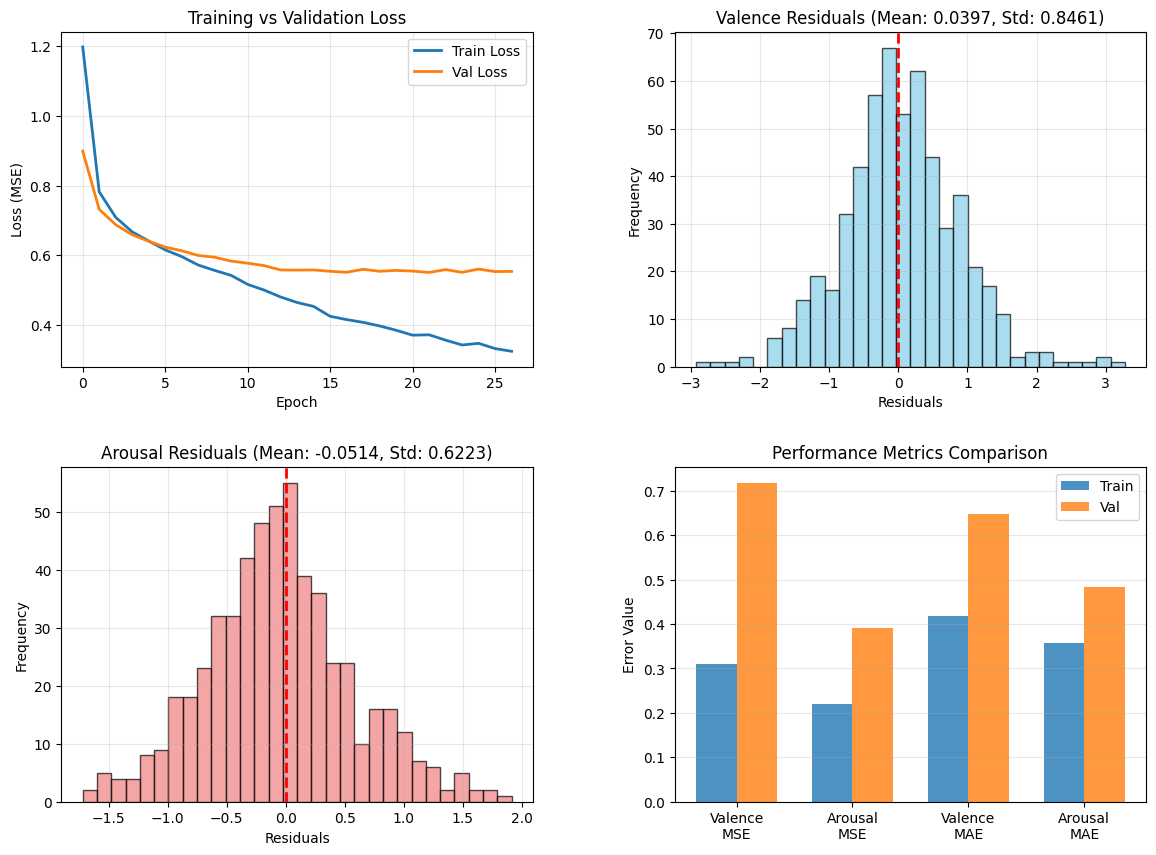

Visualization saved as 'full_baseline_performance.png'


In [8]:
# Visualization - Full Baseline Performance (simplified: plots 1, 4, 5, 9)
import seaborn as sns

fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# 1. Training vs Validation Loss
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(train_losses, label='Train Loss', linewidth=2)
ax1.plot(val_losses, label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.set_title('Training vs Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 4. Valence residuals distribution
ax4 = fig.add_subplot(gs[0, 1])
valence_residuals = y_val_np[:, 0] - val_preds_np[:, 0]
ax4.hist(valence_residuals, bins=30, alpha=0.7, edgecolor='black', color='skyblue')
ax4.set_xlabel('Residuals')
ax4.set_ylabel('Frequency')
ax4.set_title(f'Valence Residuals (Mean: {valence_residuals.mean():.4f}, Std: {valence_residuals.std():.4f})')
ax4.axvline(x=0, color='r', linestyle='--', linewidth=2)
ax4.grid(True, alpha=0.3)

# 5. Arousal residuals distribution
ax5 = fig.add_subplot(gs[1, 0])
arousal_residuals = y_val_np[:, 1] - val_preds_np[:, 1]
ax5.hist(arousal_residuals, bins=30, alpha=0.7, edgecolor='black', color='lightcoral')
ax5.set_xlabel('Residuals')
ax5.set_ylabel('Frequency')
ax5.set_title(f'Arousal Residuals (Mean: {arousal_residuals.mean():.4f}, Std: {arousal_residuals.std():.4f})')
ax5.axvline(x=0, color='r', linestyle='--', linewidth=2)
ax5.grid(True, alpha=0.3)

# 9. Performance metrics comparison
ax9 = fig.add_subplot(gs[1, 1])
metrics_names = ['Valence\nMSE', 'Arousal\nMSE', 'Valence\nMAE', 'Arousal\nMAE']
train_metrics = [train_mse_valence, train_mse_arousal, train_mae_valence, train_mae_arousal]
val_metrics = [val_mse_valence, val_mse_arousal, val_mae_valence, val_mae_arousal]

x = np.arange(len(metrics_names))
width = 0.35
ax9.bar(x - width/2, train_metrics, width, label='Train', alpha=0.8)
ax9.bar(x + width/2, val_metrics, width, label='Val', alpha=0.8)
ax9.set_ylabel('Error Value')
ax9.set_title('Performance Metrics Comparison')
ax9.set_xticks(x)
ax9.set_xticklabels(metrics_names)
ax9.legend()
ax9.grid(True, alpha=0.3, axis='y')

plt.savefig('full_baseline_performance.png', dpi=150, bbox_inches='tight')
plt.show()

print("Visualization saved as 'full_baseline_performance.png'")
